Origin notebook: [Notebook original](https://colab.research.google.com/drive/1IAA1h8u53O1hi9807u7oOFuT3728N0-n?usp=sharing)

In [ ]:
!pip install --upgrade pip
!pip install huggingface-hub==0.16.4
!pip install sentencepiece
!pip install -U transformers
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.8 MB/s eta 0:00:00


# Fine-tuning XLM-T

This notebook describes a simple case of finetuning. You can finetune either the `XLM-T` language model, or XLM-T sentiment, which has already been fine-tuned on sentiment analysis data, in 8 languages (this could be useful to do sentiment transfer learning on new languages).,

This notebook was modified from https://huggingface.co/transformers/custom_datasets.html

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

## Parameters

In [ ]:
LR = 2e-5
EPOCHS = 1
BATCH_SIZE = 16
MODEL = "cardiffnlp/twitter-xlm-roberta-base" # use this to finetune the language model
MAX_TRAINING_EXAMPLES = -1 # set this to -1 if you want to use the whole training set

## Data

We download the xml-t sentiment dataset (`UMSAB`) but you can use your own.
If you use the same files structures as [TweetEval](https://github.com/cardiffnlp/tweeteval) (`train_text.txt`, `train_labels.txt`, `val_text.txt`, `...`), you do not need to change anything in the code.

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataPathOnDrive = "/content/drive/MyDrive/Colab Notebooks/Minería de Datos - Proyecto aprendizaje supervisado (Model finetuning)/inputData"
dataToWrite = "/content/drive/MyDrive/Colab Notebooks/Minería de Datos - Proyecto aprendizaje supervisado (Model finetuning)/results/"

Mounted at /content/drive


In [ ]:
TAMAÑO_DEL_DATASET = 10000

# Leer el fichero csv
data = pd.read_csv(f'{dataPathOnDrive}/Suicide_Detection{TAMAÑO_DEL_DATASET}.csv')
assert len(data) == TAMAÑO_DEL_DATASET

# Train: 75%; Dev: 15%; Test: 10%
train, test_val = train_test_split(data, test_size=0.25, random_state=42)
val, test = train_test_split(test_val, test_size=0.4, random_state=42)

# Generamos la estructura de datos apropiada para que funcione el código del Notebook original
dataset_dict = {}
dataset_dict['train'] = {}
dataset_dict['train']['text'] = [text for text in train['text']]
dataset_dict['train']['labels'] = [0 if label == 'suicide' else 1 for label in train['class']]
assert len(dataset_dict['train']['text']) == TAMAÑO_DEL_DATASET*0.75
assert len(dataset_dict['train']['labels']) == TAMAÑO_DEL_DATASET*0.75
print(f'Train set texts: {len(dataset_dict["train"]["text"])}; labels: {len(dataset_dict["train"]["labels"])}')

dataset_dict['val'] = {}
dataset_dict['val']['text'] = [text for text in val['text']]
dataset_dict['val']['labels'] = [0 if label == 'suicide' else 1 for label in val['class']]
assert len(dataset_dict['val']['text']) == TAMAÑO_DEL_DATASET*0.15
assert len(dataset_dict['val']['labels']) == TAMAÑO_DEL_DATASET*0.15
print(f'Val set texts: {len(dataset_dict["val"]["text"])}; labels: {len(dataset_dict["val"]["labels"])}')

dataset_dict['test'] = {}
dataset_dict['test']['text'] = [text for text in test['text']]
dataset_dict['test']['labels'] = [0 if label == 'suicide' else 1 for label in test['class']]
assert len(dataset_dict['test']['text']) == TAMAÑO_DEL_DATASET*0.10
assert len(dataset_dict['test']['labels']) == TAMAÑO_DEL_DATASET*0.10
print(f'Test set texts: {len(dataset_dict["test"]["text"])}; labels: {len(dataset_dict["test"]["labels"])}')


if MAX_TRAINING_EXAMPLES > 0:
  dataset_dict['train']['text']=dataset_dict['train']['text'][:MAX_TRAINING_EXAMPLES]
  dataset_dict['train']['labels']=dataset_dict['train']['labels'][:MAX_TRAINING_EXAMPLES]

Train set texts: 7500; labels: 7500
Val set texts: 1500; labels: 1500
Test set texts: 1000; labels: 1000


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True, model_max_length=512) # Model max length is not set...

In [ ]:
train_encodings = tokenizer(dataset_dict['train']['text'], truncation=True, padding=True)
val_encodings = tokenizer(dataset_dict['val']['text'], truncation=True, padding=True)
test_encodings = tokenizer(dataset_dict['test']['text'], truncation=True, padding=True)
print(train_encodings[:2])
print(train_encodings)

[Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, dataset_dict['train']['labels'])
val_dataset = MyDataset(val_encodings, dataset_dict['val']['labels'])
test_dataset = MyDataset(test_encodings, dataset_dict['test']['labels'])

## Fine-tuning

The steps above prepared the datasets in the way that the trainer is expected. Now all we need to do is create a model
to fine-tune, define the `TrainingArguments`/`TFTrainingArguments` and
instantiate a `Trainer`/`TFTrainer`.

In [ ]:
training_args = TrainingArguments(
    evaluation_strategy = 'steps',            # when to evaluate. "steps": Evaluation is done (and logged) every eval_steps (or logging_steps=10 if eval_steps missing); "no": No evaluation is done during training; "epoch": Evaluation is done at the end of each epoch;
    output_dir='./results',                   # output directory
    num_train_epochs=EPOCHS,                  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=100,                         # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                        # strength of weight decay
    logging_dir='./logs',                     # directory for storing logs
    logging_steps=10,                         # when to print log (and to evaluate if evaluation_strategy = 'steps')
    load_best_model_at_end=True,              # load or not best model at the end
)

num_labels = len(set(dataset_dict["train"]["labels"]))
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=num_labels)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,                              # the instantiated 🤗 Transformers model to be trained
    args=training_args,                       # training arguments, defined above
    train_dataset=train_dataset,              # training dataset
    eval_dataset=val_dataset                  # evaluation dataset
)

trainer.train()

Step,Training Loss,Validation Loss
10,0.699300,0.669066
20,0.641700,0.569623
30,0.549300,0.527972
40,0.521700,0.478687
50,0.456100,0.359395
60,0.423900,0.402699
70,0.362100,0.283880
80,0.253900,0.265609
90,0.228500,0.311327
100,0.248400,0.285737


Step,Training Loss,Validation Loss
10,0.699300,0.669066
20,0.641700,0.569623
30,0.549300,0.527972
40,0.521700,0.478687
50,0.456100,0.359395
60,0.423900,0.402699
70,0.362100,0.283880
80,0.253900,0.265609
90,0.228500,0.311327
100,0.248400,0.285737


TrainOutput(global_step=469, training_loss=0.19169160985806857, metrics={'train_runtime': 2835.8697, 'train_samples_per_second': 2.645, 'train_steps_per_second': 0.165, 'total_flos': 1973332915200000.0, 'train_loss': 0.19169160985806857, 'epoch': 1.0})

In [ ]:
trainer.save_model(dataToWrite + 'best_model') # save best model

## Evaluate on Test set

In [ ]:
test_preds_raw, test_labels , _ = trainer.predict(test_dataset)
test_preds = np.argmax(test_preds_raw, axis=-1)
print(classification_report(test_labels, test_preds, digits=3))

              precision    recall  f1-score   support

           0      0.984     0.986     0.985       514
           1      0.986     0.984     0.985       486

    accuracy                          0.985      1000
   macro avg      0.985     0.985     0.985      1000
weighted avg      0.985     0.985     0.985      1000



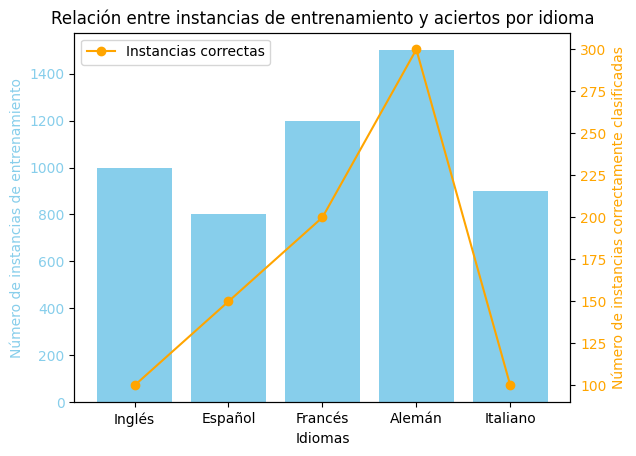

In [1]:
import matplotlib.pyplot as plt

# Datos de ejemplo: número de instancias y número de instancias correctamente clasificadas por idioma
idiomas = ['Inglés', 'Español', 'Francés', 'Alemán', 'Italiano']
instancias_entrenamiento = [1000, 800, 1200, 1500, 900]
instancias_correctas = [100, 150, 200, 300, 100]

# Crear la figura y los ejes
fig, ax1 = plt.subplots()

# Crear la gráfica de barras para el número de instancias de entrenamiento por idioma
ax1.bar(idiomas, instancias_entrenamiento, color='skyblue', label='Instancias de entrenamiento')
ax1.set_xlabel('Idiomas')
ax1.set_ylabel('Número de instancias de entrenamiento', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Crear la gráfica de línea para el número de instancias correctamente clasificadas
ax2 = ax1.twinx()  # Crear un segundo eje y
ax2.plot(idiomas, instancias_correctas, color='orange', marker='o', label='Instancias correctas')
ax2.set_ylabel('Número de instancias correctamente clasificadas', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Añadir leyendas
plt.legend()

# Mostrar el gráfico
plt.title('Relación entre instancias de entrenamiento y aciertos por idioma')
plt.show()

<a id='ft_native'></a>